<a href="https://colab.research.google.com/github/jvSett/Single-point_radio-direction/blob/main/Radio_Direction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Загружаем необходимые библиотеки**

In [1]:
import h5py
import numpy as np
from google.colab import files
import sys
import torch
import warnings
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
plt.style.use('classic')

import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
%matplotlib inline

In [2]:
%cd /content

/content


In [ ]:
!mkdir /content/data

**2. Подгружаем датасет**

In [4]:
%cd /content/data/

/content/data


In [ ]:
!gdown 1W1AbRTznhhE9Ck1ZP1vDIhm4kgFrLoG4

In [ ]:
!unzip /content/data/data1.zip

In [7]:
PATH = "/content/data/data1/"

**3. Предобработка данных**

Приведем сигнальные вектора к действительным векторам  и выровним данные

In [ ]:
na = 3             # число каналов
nb = 10            # число блоков в одном измерении
nd = 45250 #22750         # число измерений
x0 = np.zeros((3,10, nd, 4*4), dtype=np.complex64)
y0 = np.zeros((nd ,4*4), dtype=np.float32)
ii = 0
# ff - число реализаций квазипериодов поляризационных замираний
for ff in (1, 2, 5, 10): 
  for snr in (30, 20, 10, 0):  #snr - соотношение сигнал/шум
    with h5py.File(PATH+"/train_{0}_10_{1}_4525.hdf5".format(ff, snr), 'r') as f:
      d1 = f['X']
      d2 = f['Y']
      x0[:, :, :, ii] = d1[:, :, :nd]
      y0[:, ii] = d2[:nd]
      ii += 1
print(x0.shape)
print(y0.shape)

In [ ]:
x = np.reshape(x0,(3, 10, nd*16))
y = np.reshape(y0, nd*16)
print(x.shape)
print(y.shape)

print(np.mean(np.real(x[1, :, :])), np.mean(np.imag(x[1, :, :])))
print(np.std(np.abs(x[1, :, :])), np.std(np.abs(x[0, :, :])))

In [10]:
def creatXY_complex(x,y):
  n = x.shape[2]
  xx = np.reshape(x, (3*10, n)).transpose()
  X = np.c_[np.real(xx), np.imag(xx)]
  Xmean = X.mean()
  Xm = X 
  Y= np.reshape(y, (n, 1))
  x_train, x_test, y_train, y_test = train_test_split(Xm, Y, test_size=0.1)
  return x_train, x_test, y_train, y_test, Xmean

Формирование обучающей и тестовой выборки массива входных данных

In [11]:
x_train, x_test, y_train, y_test,Xmean  = creatXY_complex(x, y)

In [12]:
def fetch_batch(x, y, batch_index, batch_size):
  start = batch_index*batch_size
  end = batch_index*batch_size+batch_size
  x_batch = x[start:end]
  y_batch = y[start:end]
  return x_batch, y_batch
  

**4. Создаем сетку, с нужными нам параметрами**

In [ ]:
nf=nb*na*2
print(nf)
class Net(nn.Module):
  def __init__(self, input_dim=nf, out_dim=1, lsize1=100, lsize2=50):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(input_dim, lsize1)
    self.fc2 = nn.Linear(lsize1, lsize2)
    self.logit = nn.Linear(lsize2, out_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.logit(x)
    return x

In [14]:
use_cuda = True
#lambda_l1 = 0.0001
def train(net, x_train, y_train, x_test, y_test, epoches=200, lr=0.1, wregul=0.0001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wregul)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
    N_EPOCHES = epoches
    BS = 2000
    n_batches = int(np.ceil(x_train.shape[0] / BS))
    train_losses = []
    test_losses = []
    for i in range(N_EPOCHES):
        scheduler.step()
        
        for bi in range(n_batches):
            x_batch, y_batch = fetch_batch(x_train, y_train, bi, BS)
            x_train_var = Variable(torch.from_numpy(x_batch))
            y_train_var = Variable(torch.from_numpy(y_batch))
            optimizer.zero_grad()
            if use_cuda and torch.cuda.is_available():
              x_train_var = x_train_var.cuda()
              y_train_var = y_train_var.cuda()
            
            outputs = net(x_train_var)
            loss = torch.std(outputs - y_train_var)
            loss.backward()
            optimizer.step()
        with torch.no_grad():

            x_test_var = Variable(torch.from_numpy(x_test))
            y_test_var = Variable(torch.from_numpy(y_test))
            if use_cuda and torch.cuda.is_available():
              x_test_var = x_test_var.cuda()
              y_test_var = y_test_var.cuda()
            outputs = net(x_test_var)
            test_loss = torch.std(outputs- y_test_var)
            test_losses.append(test_loss.item())
            train_losses.append(loss.item())
        if i%10 == 0:
            sys.stdout.write('Iter: %d, test loss: %.8f, train loss: %.8f \n'
                             %(i, test_loss.item(), loss.item()))
            print(scheduler.get_lr())
            sys.stdout.flush()
    return train_losses, test_losses

Запуск сетки и ее обучение

In [ ]:
net = Net(input_dim=nb*na*2, lsize1=100, lsize2=50)
net.cuda()
print(net, x_train.shape, y_train.shape, x_test.shape, y_test.shape)
t0 = time.time()
train_losses, test_losses = train(net, x_train, y_train, x_test, y_test, lr=.01, epoches=300, wregul=0.0001)
t1 = time.time()
print("time learning {0}".format(t1-t0))

Построим график СКО в зависимости от шага обучения

(0.0, 6.0)

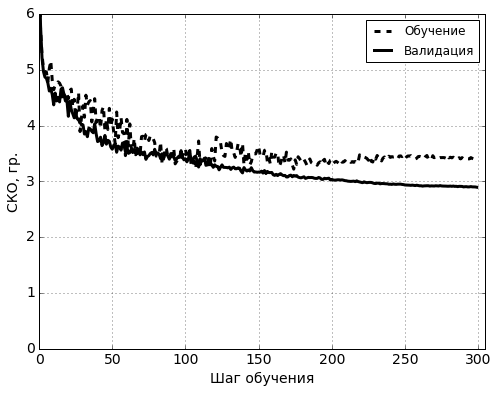

In [16]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, "--", linewidth=3, label = "Обучение", color="black")
plt.plot(test_losses, linewidth=3, label = "Валидация", color="black")
plt.xlabel("Шаг обучения", size=14)
plt.ylabel("СКО, гр.", size=14)
plt.legend()
plt.grid()
plt.xlim((0,305))
plt.ylim((0,6))


Попробуем изменить количество эпох и регуляризацию

In [ ]:
net = Net(input_dim=nb*na*2, lsize1=100, lsize2=50)
net.cuda()
print(net, x_train.shape, y_train.shape, x_test.shape, y_test.shape)
t0 = time.time()
train_losses, test_losses = train(net, x_train, y_train, x_test, y_test, lr=.01, epoches=500, wregul=0.0002)
t1 = time.time()
print("time learning {0}".format(t1-t0))

(0.0, 6.0)

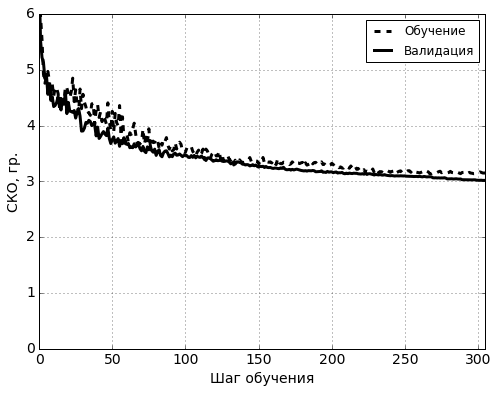

In [35]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, "--", linewidth=3, label = "Обучение", color="black")
plt.plot(test_losses, linewidth=3, label = "Валидация", color="black")
plt.xlabel("Шаг обучения", size=14)
plt.ylabel("СКО, гр.", size=14)
plt.legend()
plt.grid()
plt.xlim((0,305))
plt.ylim((0,6))

In [17]:
def testnet(net,x,y):
  x_var = Variable(torch.from_numpy(x))
  if use_cuda and torch.cuda.is_available():
    x_var = x_var.cuda()
  outputs = net(x_var)
  a = outputs.cpu().detach().numpy()
  return a

2.4699452 2.8941472
98.01809 98.01224


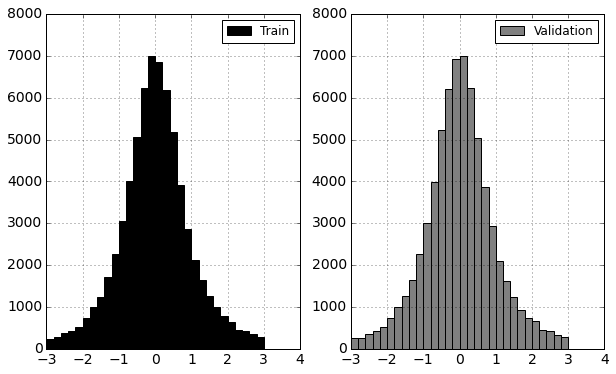

In [18]:
n = y_test.size
y0 = testnet(net, x_train[:n], y_train[:n])
y1 = testnet(net, x_test[:n], y_test[:n])
q0 = y_train[:n]-y0
q1 = y_test-y1
shift = np.mean(q0) 

print(np.std(q0),np.std(q1))
print(np.mean(q0),np.mean(q1))
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist((q0-shift), bins=30, range=(-3,3), density=False, color="black", label ="Train")
plt.grid()
plt.legend()


plt.subplot(122)
plt.hist(q1-shift, bins=30, range=(-3,3), density=False, color="grey", label ="Validation")   
plt.legend()
plt.grid()      


**5. Протеистируем наш алгоритм на определенных параметрах и скомбинируем его с АППЗ без ИНС**

In [28]:
ny = 16
fading = (0.1,0.2,0.5,1)
a = 3             # число каналов
nb = 10            # число блоков в одном измерении
nd = 2275*1         # число измерений
tx0 = np.zeros((3,10, nd, 4*ny), dtype=np.complex64)
ty0 = np.zeros((nd, 4*ny), dtype=np.float32)
ii = 0
par = []
ii = 0
for ff in (1, 2, 5, 10):
  for snr in range(0,ny*2,2):
    par.append((snr,ff))
    with h5py.File(PATH+"test_{0}_2_{1}_2275.hdf5".format(ff,snr), 'r') as f:  
      d1 = f['X']
      d2 = f['Y']
      tx0[:, :, :, ii]=d1[:, :, :nd]
      ty0[:, ii]=d2[:nd]
      ii += 1

In [29]:
def creatXY1_complex(x,y):
  n = x.shape[2]
  xx = np.reshape(x, (3*10,n)).transpose()
  X = np.c_[np.real(xx), np.imag(xx)]
  Xm = X 
  Y= np.reshape(y, (n,1))
  return Xm, Y

In [30]:
qstd = []

In [31]:
def p3(x):
  r = np.dot(x, x.transpose().conj())
  sv, sw = np.linalg.eigh(r)
  ind = np.argmin(sv)
  w = sw[:, ind]
  return np.arctan2(np.abs(w[0]), np.abs(w[1]))*180/np.pi

In [32]:
qstd1 = []
qstd2 = []
qstd3 = []

for i in range(ny*4):
  x_train0, y_train0  = creatXY1_complex(tx0[:, :, :, i], ty0[:, i])
  y0 = testnet(net, x_train0[:], y_train0[:])
  q0 = y_train0[:]-y0-shift # ИНС

  qstd1.append(np.std(q0))
  wout = np.zeros(nd)
  for j  in range(nd):
    out0 = p3(tx0[:, :, j, i])
    wout[j] = out0
  q1 = ty0[:, i]-wout # АППЗ
  qstd2.append(np.std(q1))
  qstd3.append(np.std((q1+q0)*0.5)) # ИНС + АППЗ


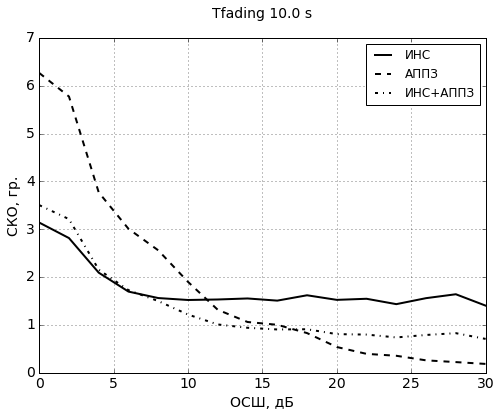

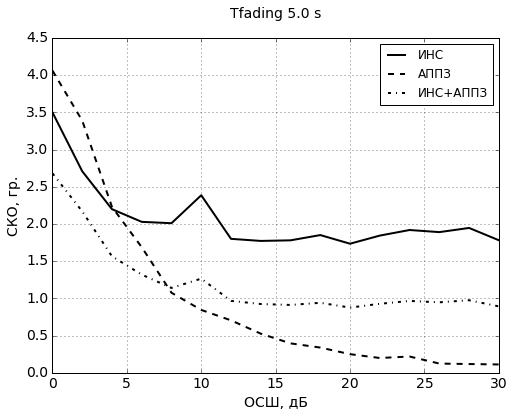

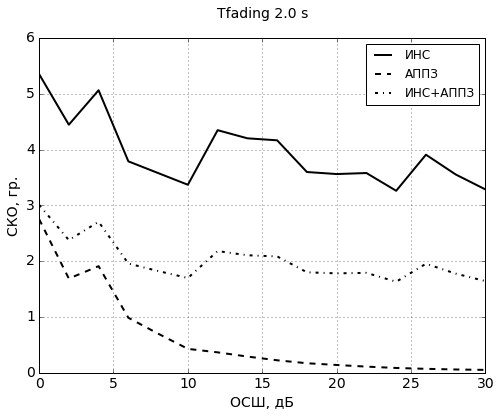

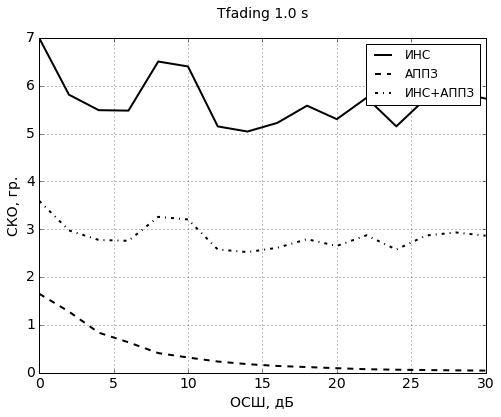

In [33]:

snr = np.arange(0, ny*2, 2)
for i in range(4):
  plt.figure(figsize=(8,6))
  plt.plot(snr, qstd1[i*ny:ny*i+ny], "-", color="black", label="ИНС", linewidth=2);
  plt.plot(snr, qstd2[i*ny:ny*i+ny], "--", color="black", label="АППЗ", linewidth=2);
  plt.plot(snr, qstd3[i*ny:ny*i+ny], "-.", color="black", label="ИНС+АППЗ", linewidth=2);
  plt.grid()
  plt.xlabel("ОСШ, дБ", size = 14)
  plt.ylabel("СКО, гр.", size = 14)
  plt.legend()
  plt.title("Tfading {} s".format(1/fading[i]), size = 14, pad =20)
  plt.show()
  

